In [1]:
import numpy as np
import pyccl as ccl
import rosatX as rx
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

## 1 Read ROSAT response and precompute integrated spectrum

In [2]:
kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0
rosat = rx.ROSATResponse('pspcc_gain1_256.rsp')
J_cont = rosat.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax,
                                              dolines=False, dopseudo=False)
J_tot = rosat.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax)

## 2 Initialize profiles and tracers

In [3]:
cosmo = ccl.CosmologyVanillaLCDM()
mdef = ccl.halos.MassDef200c()
cM = ccl.halos.ConcentrationDuffy08(mdef=mdef)
# Gas number density
dens = rx.HaloProfileDensityBattaglia(kind='n_total')
# Pressure
pres = rx.HaloProfilePressureBattaglia(kind='P_total')
# Matter density
dmat = ccl.halos.HaloProfileNFW(cM)
# X-ray (continuum only)
xcont = rx.HaloProfileXray(dens, pres, J_cont)
# X-ray (line + continuum)
xtot = rx.HaloProfileXray(dens, pres, J_tot)

Precompute parameters of Fourier-space profiles (pretty slow)

In [4]:
with ccl.UnlockInstance(xcont):
    xcont._get_fourier_params(cosmo, mdef)
with ccl.UnlockInstance(xtot):
    xtot._get_fourier_params(cosmo, mdef)

/home/damonge/Science/PossibleProjects/2023_ROSATx/xCell-likelihoods/papers/ROSATx/rosatX/profiles.py:567: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fhi = np.array([quad(lambda y: np.exp(f(np.log(y)))*y,
/home/damonge/Science/PossibleProjects/2023_ROSATx/xCell-likelihoods/papers/ROSATx/rosatX/profiles.py:572: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (si

Plot real and Fourier-space profiles

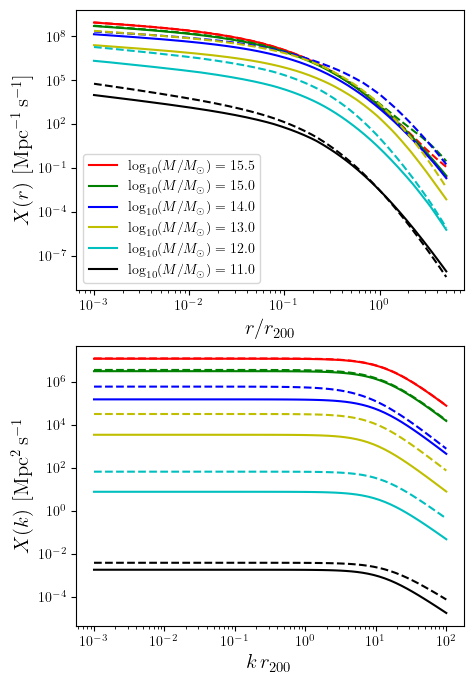

<Figure size 640x480 with 0 Axes>

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(5, 8))
ax1, ax2 = axs
plt.figure()
a = 1.
x_out = 5
for c, lM in zip(['r', 'g', 'b', 'y', 'c', 'k'], [15.5, 15, 14, 13, 12, 11]):
    M = 10.**lM
    r200 = mdef.get_radius(cosmo, M, a) / a
    x = np.geomspace(1E-3, x_out, 256)
    q = np.geomspace(1E-3, 100, 64)
    fx = xcont.real(cosmo, r200*x, M, a, mdef)
    ax1.plot(x, fx, c+'-', label=r'$\log_{10}(M/M_\odot)=%.1lf$' % lM)
    fx = xtot.real(cosmo, r200*x, M, a, mdef)
    ax1.plot(x, fx, c+'--')
    # Fourier
    fq = xcont.fourier(cosmo, q/r200, M, a, mdef)
    ax2.plot(q, fq, c+'-')
    fq = xtot.fourier(cosmo, q/r200, M, a, mdef)
    ax2.plot(q, fq, c+'--')
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
ax1.legend()
ax1.set_ylabel(r'$X(r)\,\,[{\rm Mpc}^{-1}\,{\rm s}^{-1}]$', fontsize=15)
ax2.set_ylabel(r'$X(k)\,\,[{\rm Mpc}^2\,{\rm s}^{-1}$', fontsize=15)
ax1.set_xlabel(r'$r/r_{200}$', fontsize=15)
ax2.set_xlabel(r'$k\,r_{200}$', fontsize=15);

## 3 Generate radial tracers

We generate galaxy clustering and shear tracers for some imaginary sample at $z\sim0.5$ with $\sigma_z\sim0.05$

In [6]:
zs = np.linspace(0., 1., 512)
nz = np.exp(-0.5*((zs-0.5)/0.05)**2)

# X-ray tracer
tx = rx.XrayTracer(cosmo)
# delta_g tracer
tg = ccl.NumberCountsTracer(cosmo, False, dndz=(zs, nz), bias=(zs, np.ones_like(nz)))
# gamma tracer
ts = ccl.WeakLensingTracer(cosmo, dndz=(zs, nz))

## 4 Inspect the halo profiles a bit

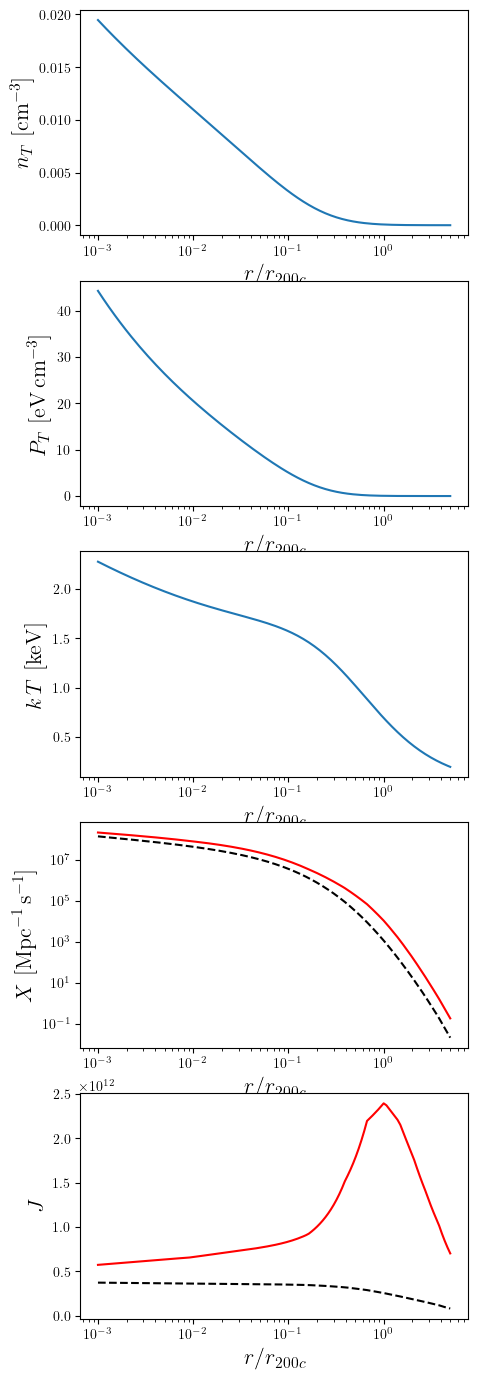

In [7]:
M = 1E14
a = 1.
r200 = mdef.get_radius(cosmo, M, a) / a
x = np.geomspace(0.001, 5, 128)
r = r200*x
p_dens = dens.real(cosmo, r, M, a, mdef)
p_pres = pres.real(cosmo, r, M, a, mdef)
p_dmat = dmat.real(cosmo, r, M, a, mdef)
p_xtot = xtot.real(cosmo, r, M, a, mdef)
p_xcont = xcont.real(cosmo, r, M, a, mdef)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(5, 17))
ax1.plot(x, p_dens)
ax1.set_xlabel(r'$r/r_{200c}$', fontsize=16)
ax1.set_ylabel(r'$n_T\,\,[{\rm cm}^{-3}]$', fontsize=16)
ax1.set_xscale('log')

ax2.plot(x, p_pres)
ax2.set_xlabel(r'$r/r_{200c}$', fontsize=16)
ax2.set_ylabel(r'$P_T\,\,[{\rm eV}\,{\rm cm}^{-3}]$', fontsize=16)
ax2.set_xscale('log')

ax3.plot(x, 1E-3*p_pres/p_dens)
ax3.set_xlabel(r'$r/r_{200c}$', fontsize=16)
ax3.set_ylabel(r'$k\,T\,\,[{\rm keV}]$', fontsize=16)
ax3.set_xscale('log')

ax4.plot(x, p_xtot, 'r-')
ax4.plot(x, p_xcont, 'k--')
ax4.set_xlabel(r'$r/r_{200c}$', fontsize=16)
ax4.set_ylabel(r'$X\,\,[{\rm Mpc}^{-1}\,{\rm s}^{-1}]$', fontsize=16)
ax4.set_xscale('log')
ax4.set_yscale('log')

ax5.plot(x, p_xtot/p_dens**2, 'r-')
ax5.plot(x, p_xcont/p_dens**2, 'k--')
ax5.set_xlabel(r'$r/r_{200c}$', fontsize=16)
ax5.set_ylabel(r'$J$', fontsize=16)
ax5.set_xscale('log');

## 5 Compute halo model power spectra

In [8]:
nM = ccl.halos.MassFuncTinker08(cosmo, mdef)
bM = ccl.halos.HaloBiasTinker10(cosmo, mdef)
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, mdef, log10M_max=15., log10M_min=10, nlog10M=32)

In [9]:
k_arr = np.geomspace(1E-4,1E2,256)
a_arr = np.linspace(0.3,1,8)
pk_MMf = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                                normprof1=True,
                                lk_arr=np.log(k_arr), a_arr=a_arr,
                                is_logp=False)

In [10]:
pk_Mx1f = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                                 normprof1=True, prof2=xcont, normprof2=False,
                                 lk_arr=np.log(k_arr), a_arr=a_arr,
                                 is_logp=False)
pk_Mx2f = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                                 normprof1=True, prof2=xtot, normprof2=False,
                                 lk_arr=np.log(k_arr), a_arr=a_arr,
                                 is_logp=False)

In [11]:
pk_xx1f = ccl.halos.halomod_Pk2D(cosmo, hmc, xcont,
                                 normprof1=False, prof2=xcont, normprof2=False,
                                 lk_arr=np.log(k_arr), a_arr=a_arr,
                                 is_logp=False)
pk_xx2f = ccl.halos.halomod_Pk2D(cosmo, hmc, xtot,
                                 normprof1=False, prof2=xtot, normprof2=False,
                                 lk_arr=np.log(k_arr), a_arr=a_arr,
                                 is_logp=False)

[]

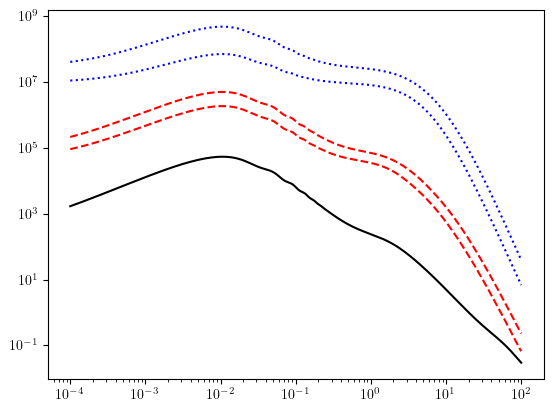

In [12]:
a = 1/(1+0.5)
plt.plot(k_arr, pk_MMf.eval(k_arr, a, cosmo), 'k-')
plt.plot(k_arr, pk_Mx1f.eval(k_arr, a, cosmo), 'r--')
plt.plot(k_arr, pk_Mx2f.eval(k_arr, a, cosmo), 'r--')
plt.plot(k_arr, pk_xx1f.eval(k_arr, a, cosmo), 'b:')
plt.plot(k_arr, pk_xx2f.eval(k_arr, a, cosmo), 'b:')
plt.loglog()
         

## 6 Compute angular power spectra

Text(0, 0.5, '$C_\\ell$')

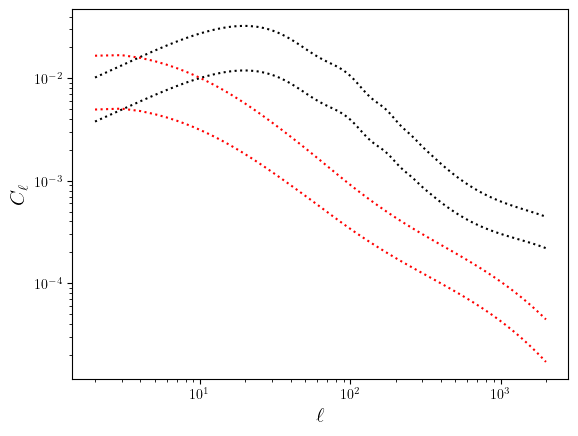

In [13]:
ls = np.unique(np.geomspace(2, 2000, 128).astype(int)).astype(float)
cl_gx1 = ccl.angular_cl(cosmo, tg, tx, ls, p_of_k_a=pk_Mx1f)
cl_gx2 = ccl.angular_cl(cosmo, tg, tx, ls, p_of_k_a=pk_Mx2f)
cl_sx1 = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_Mx1f)
cl_sx2 = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_Mx2f)

plt.plot(ls, cl_gx1, 'k:')
plt.plot(ls, cl_gx2, 'k:')
plt.plot(ls, cl_sx1, 'r:')
plt.plot(ls, cl_sx2, 'r:')
plt.loglog()
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)